In [16]:
"Importing Libraries"


import numpy as np
import tensorflow as tf
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, GRU, Dropout, Input, Layer, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import date, timedelta, datetime 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import Model
import keras.backend as K
import gspread
from google.auth import default
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [17]:
import os
os.getcwd()
df = pd.read_excel("../Data/BTC Traditional Price Data (16_2_18 - 31_10_20).xlsx")
df = pd.DataFrame.from_records(df)
df.set_index('Date', inplace=True)
for col in df.columns:
    df[col] = df[col].astype('float32')
df

C:\Users\IraniaN\AppData\Local\Temp\ipykernel_10916\1691531014.py:4: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(df)


,Open,High,Low,Close,BTC Price,Volume
Date,,,,,,
2018-02-16,10135.700195,10324.099609,9824.820312,10233.900391,10233.900391,7.300000e+09
2018-02-17,10207.500000,11139.500000,10149.400391,11112.700195,11112.700195,8.660000e+09
2018-02-18,11123.400391,11349.799805,10326.000000,10551.799805,10551.799805,8.740000e+09
2018-02-19,10552.599609,11273.799805,10513.200195,11225.299805,11225.299805,7.650000e+09
2018-02-20,11231.799805,11958.500000,11231.799805,11403.700195,11403.700195,9.930000e+09
...,...,...,...,...,...,...
2020-10-27,13075.240234,13759.669922,13060.839844,13654.219727,13654.219727,3.370000e+10
2020-10-28,13654.209961,13837.700195,12932.250000,13271.290039,13271.290039,3.590000e+10
2020-10-29,13271.299805,13612.049805,12980.059570,13437.879883,13437.879883,5.650000e+10


Imports and gets current directory: The os module is imported, and os.getcwd() returns the current working directory.
Reads Excel file: pd.read_excel() reads the specified Excel file into a DataFrame.
Ensures DataFrame creation: pd.DataFrame.from_records(df) ensures df is a DataFrame (often redundant since read_excel() already creates a DataFrame).
Sets the 'Date' column as the index: df.set_index('Date', inplace=True) sets the 'Date' column as the DataFrame index.
Converts columns to float32: A for loop iterates over the columns and converts each column's data type to float32 using df[col] = df[col].astype('float32').
The final result is a DataFrame with the 'Date' index and all numeric columns converted to float32.

In [18]:
train_df = pd.DataFrame(df.copy())
train_df_ext = train_df.copy()
train_df_ext['Prediction'] = train_df_ext['BTC Price']
nrows = train_df.shape[0]
train_data_unscaled = np.array(train_df)
np_data = np.reshape(train_data_unscaled, (nrows, -1))
print("Train Data Set Shape: ", np_data.shape)

# Scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_unscaled)
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(train_df_ext['BTC Price'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

# Partitioning
sequence_length = 30
index_Close = train_df_ext.columns.get_loc("BTC Price")
train_data_len = math.ceil(train_data_scaled.shape[0] * 0.85)
train_data = train_data_scaled[0:train_data_len, :]
test_data = train_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i - sequence_length:i, :]) 
        y.append(data[i, index_Close])
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print("X_train and y_train shapes: ", x_train.shape, y_train.shape)
print("x_test and y_test shapes: ", x_test.shape, y_test.shape)


Train Data Set Shape:  (989, 6)
X_train and y_train shapes:  (811, 30, 6) (811,)
x_test and y_test shapes:  (148, 30, 6) (148,)


DataFrame creation and copying: Copies of the original DataFrame are made.
Adding a 'Prediction' column: A new column 'Prediction' is added with values from 'BTC Price'.
Converting DataFrame to numpy array: Converts the DataFrame to a numpy array and reshapes it.
Scaling: Uses MinMaxScaler to scale the data for normalization.
Data splitting: Divides data into training (85%) and testing sets, including a sequence length for temporal data.
Partition function: A function creates sequences and labels for model training and testing.
Data partitioning: Applies the function to generate x_train, y_train, x_test, and y_test.
Shape printing: Prints the shapes of training and testing sets to ensure correct data preparation.
This prepares the data for training a deep learning model such as an RNN or LSTM for predicting Bitcoin prices or similar data.

In [19]:
# Define the input shape for the model
input_shape = (x_train.shape[1], x_train.shape[2])  # Shape without additional dimension

import time
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Assuming you want to predict a single value

# Compile the model
start_time = time.time()
model.compile(optimizer='adam', loss='mse')

c:\Users\IraniaN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


This code defines and compiles a 1D Convolutional Neural Network (CNN) for sequential data processing:

Input shape definition: Sets the input shape for the model using the training data dimensions.

Model creation: A Sequential model is initialized.

Adding layers:

Conv1D layer: Adds a 1D convolutional layer with 64 filters, kernel size 3, and ReLU activation for feature extraction.

MaxPooling1D layer: Adds a max pooling layer with a pool size of 2 to reduce dimensionality.

Flatten layer: Flattens the output to a 1D array for the dense layers.

Dense layer: Adds a fully connected layer with 64 neurons and ReLU activation.

Output Dense layer: Adds a final fully connected layer with 1 neuron for single-value prediction.

Model compilation: Compiles the model with the Adam optimizer and mean squared error (mse) as the loss function.

Timing start: Records the start time for measuring execution time.

This code prepares a 1D CNN for training on sequential data, suitable for tasks like time series prediction.

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0594 - val_loss: 0.0063
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - val_loss: 0.0146
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss:

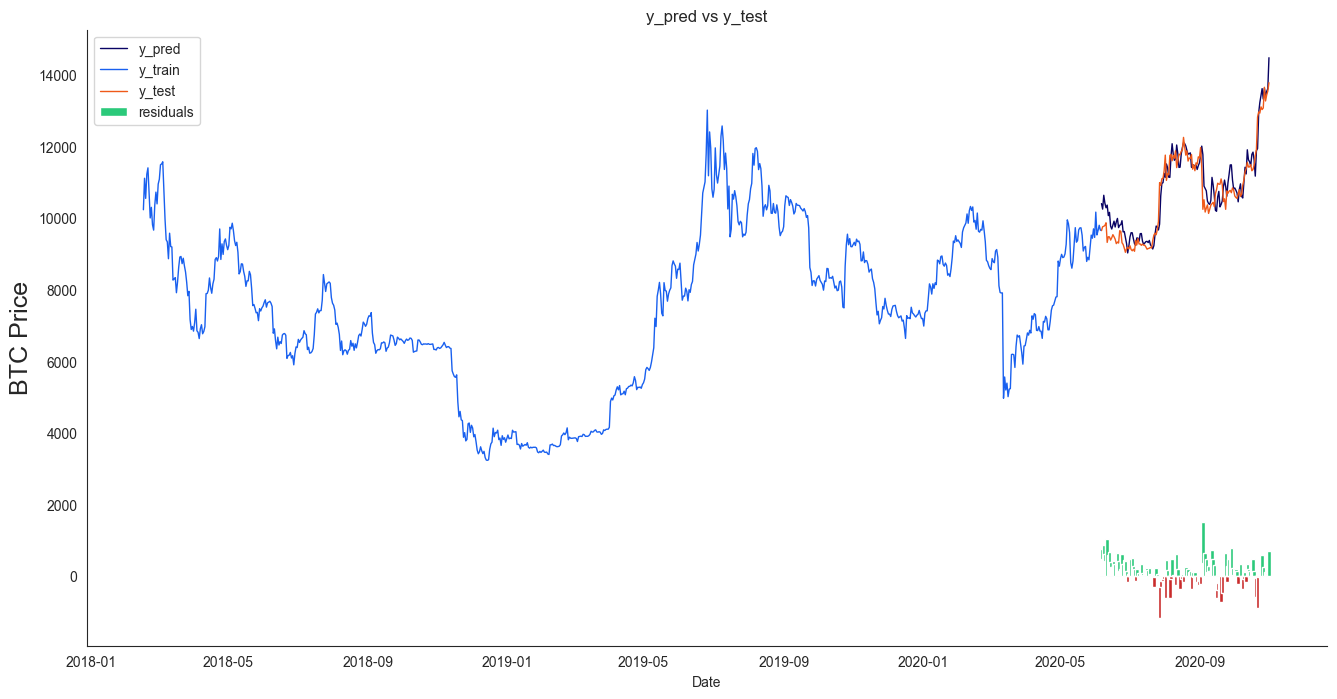

In [20]:
history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), verbose=1)

# Evaluate the model
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

# Inverse scaling on the predictions
y_train_pred = scaler_pred.inverse_transform(y_train_pred)
y_test_pred = scaler_pred.inverse_transform(y_test_pred)
y_train_unscaled = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
r2 = r2_score(y_test_unscaled, y_test_pred)
print(f'R2: {np.round(r2, 4)}')

MAE = mean_absolute_error(y_test_unscaled, y_test_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_test_pred) / y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)}')

# The date from which on the date is displayed
display_start_date = "2018-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df_ext['BTC Price'][:train_data_len + 1]).rename(columns={'BTC Price': 'y_train'})
valid = pd.DataFrame(train_df_ext['BTC Price'][train_data_len:]).rename(columns={'BTC Price': 'y_test'})

# Get the predicted values from the model
y_pred = model.predict(x_test)
predictions_unscaled = scaler_pred.inverse_transform(y_pred.reshape(-1, 1))
valid.insert(1, "y_pred", predictions_unscaled, True)

valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("BTC Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)

plt.legend()
plt.show()


Model training: model.fit() trains the model on the training data (x_train, y_train) for 200 epochs with a batch size of 64, using x_test and y_test for validation.

Predictions: The model makes predictions on both training and testing data with model.predict(), and the total execution time is printed.

Inverse scaling: The predicted (y_train_pred, y_test_pred) and actual (y_train_unscaled, y_test_unscaled) values are converted back to their original scale using inverse_transform.

Evaluation metrics:

R² score is calculated and printed.

Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) are computed and displayed.

Data preparation for comparison:

Actual y_train and y_test data are placed into train and valid DataFrames.

Predicted values are added to valid, and residuals (differences between actual and predicted values) are calculated.

Combining data and filtering:

The train and valid DataFrames are merged into df_union, and df_union_zoom filters the data from a specified start date for visualization.

Visualization:

A line plot using sns.lineplot shows actual (y_test) and predicted (y_pred) prices.

A bar plot visualizes residuals, with positive residuals in green and negative in red.

The plot includes titles, axis labels, and color settings, and is displayed with plt.show().

This code helps assess the model's predictive performance by visualizing and analyzing actual vs. predicted results.